# 1. Reading And Understanding The Data

In [1590]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1591]:
dataset = pd.read_csv(".../CarPrice_Assignment.csv", index_col=0)

In [1592]:
print(dataset.shape)

(205, 25)


In [1593]:
print(dataset.head())

        symboling                   CarName fueltype aspiration doornumber  \
car_ID                                                                       
1               3        alfa-romero giulia      gas        std        two   
2               3       alfa-romero stelvio      gas        std        two   
3               1  alfa-romero Quadrifoglio      gas        std        two   
4               2               audi 100 ls      gas        std       four   
5               2                audi 100ls      gas        std       four   

            carbody drivewheel enginelocation  wheelbase  carlength  ...  \
car_ID                                                               ...   
1       convertible        rwd          front       88.6      168.8  ...   
2       convertible        rwd          front       88.6      168.8  ...   
3         hatchback        rwd          front       94.5      171.2  ...   
4             sedan        fwd          front       99.8      176.6  ... 

In [1594]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 25 columns):
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm             205 non-null int64
citympg      

There are no null values in the dataset. On the other hand, there are some categorical variables.

# 2. Cleaning The Data

Some car names are badly written in the dataset. We need to fix them to get more accurate results.
 * maxda = mazda 
 * toyouta = toyota
 * vokswagen = volkswagen
 * vw = volkswagen
 * porcshce = porsche
 * Nissan = nissan

In [1595]:
dataset['CarName'] = dataset['CarName'].str.split(' ',expand =True)[0]

In [1596]:
print(dataset['CarName'].unique())

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


In [1597]:
dataset['CarName'] = dataset['CarName'].replace({'maxda': 'mazda', 'porcshce': 'porsche', 'toyouta': 'toyota', 
                                                 'vokswagen': 'volkswagen', 'vw': 'volkswagen', 'Nissan': 'nissan'})

In [1598]:
print(dataset.duplicated().sum())

0


# 3. Exploratory Data Analysis

Firstly, it is better to check car price distribution.

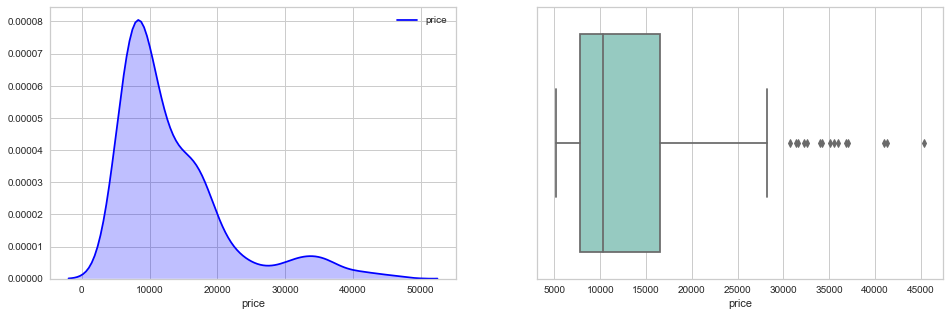

In [1599]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.kdeplot(dataset['price'],  color='blue', shade=True)
plt.xlabel("price")

plt.subplot(1,2,2)
sns.boxplot(dataset['price'], palette="Set3")

plt.show()

Car price distribution is left skewed. On the other hand, there are some outliers in the dataset. Since linear regression is sensitive to outliers, I will analyze them later.

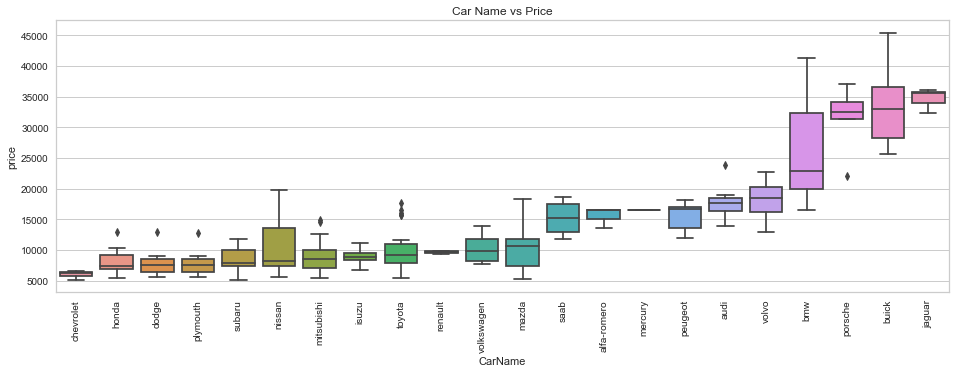

In [1600]:
plt.figure(figsize=(16,5))
sorted = dataset.groupby(['CarName'])['price'].median().sort_values()
sns.boxplot(x=dataset['CarName'], y=dataset['price'], order = list(sorted.index))
plt.title("Car Name vs Price")
plt.xticks(rotation=90)
plt.show()

Chevrolet is the cheapest car. Honda, Dodge, Plymouth has cheap prices, but these cars have some outlier prices. Bmw, Porsche, Buick, Jaguar has the highest prices.

Linear regression assumes the linear relationships between the features and the target. Firstly, I will check the linear relationship between variables visually. After that, I will analyze Pearson Correlation and P-values to be able to understand the correlation. If the correlation is weak, I will drop related variables.

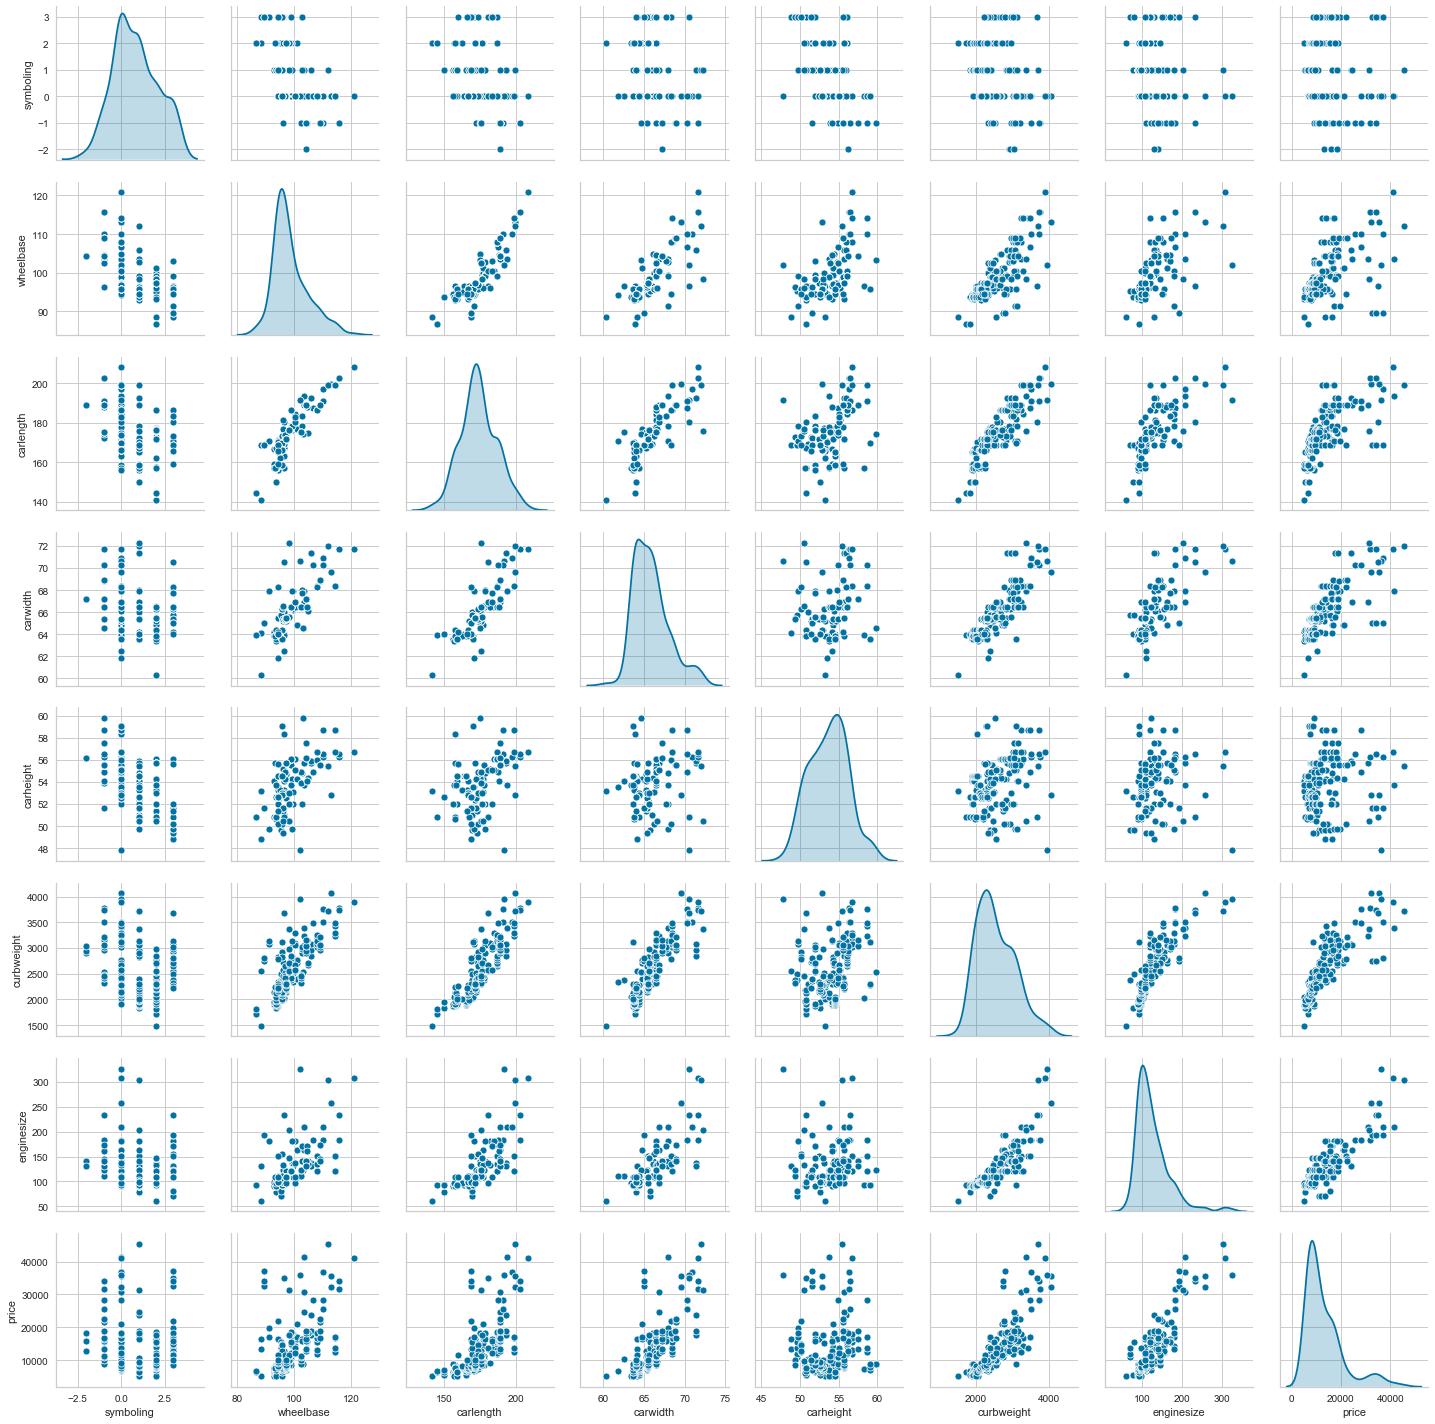

In [1601]:
sns.pairplot(dataset, diag_kind="kde", vars=['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'price'])
plt.show()

Symboling and Carheight doesn't affect price. There is not a linear relationship.

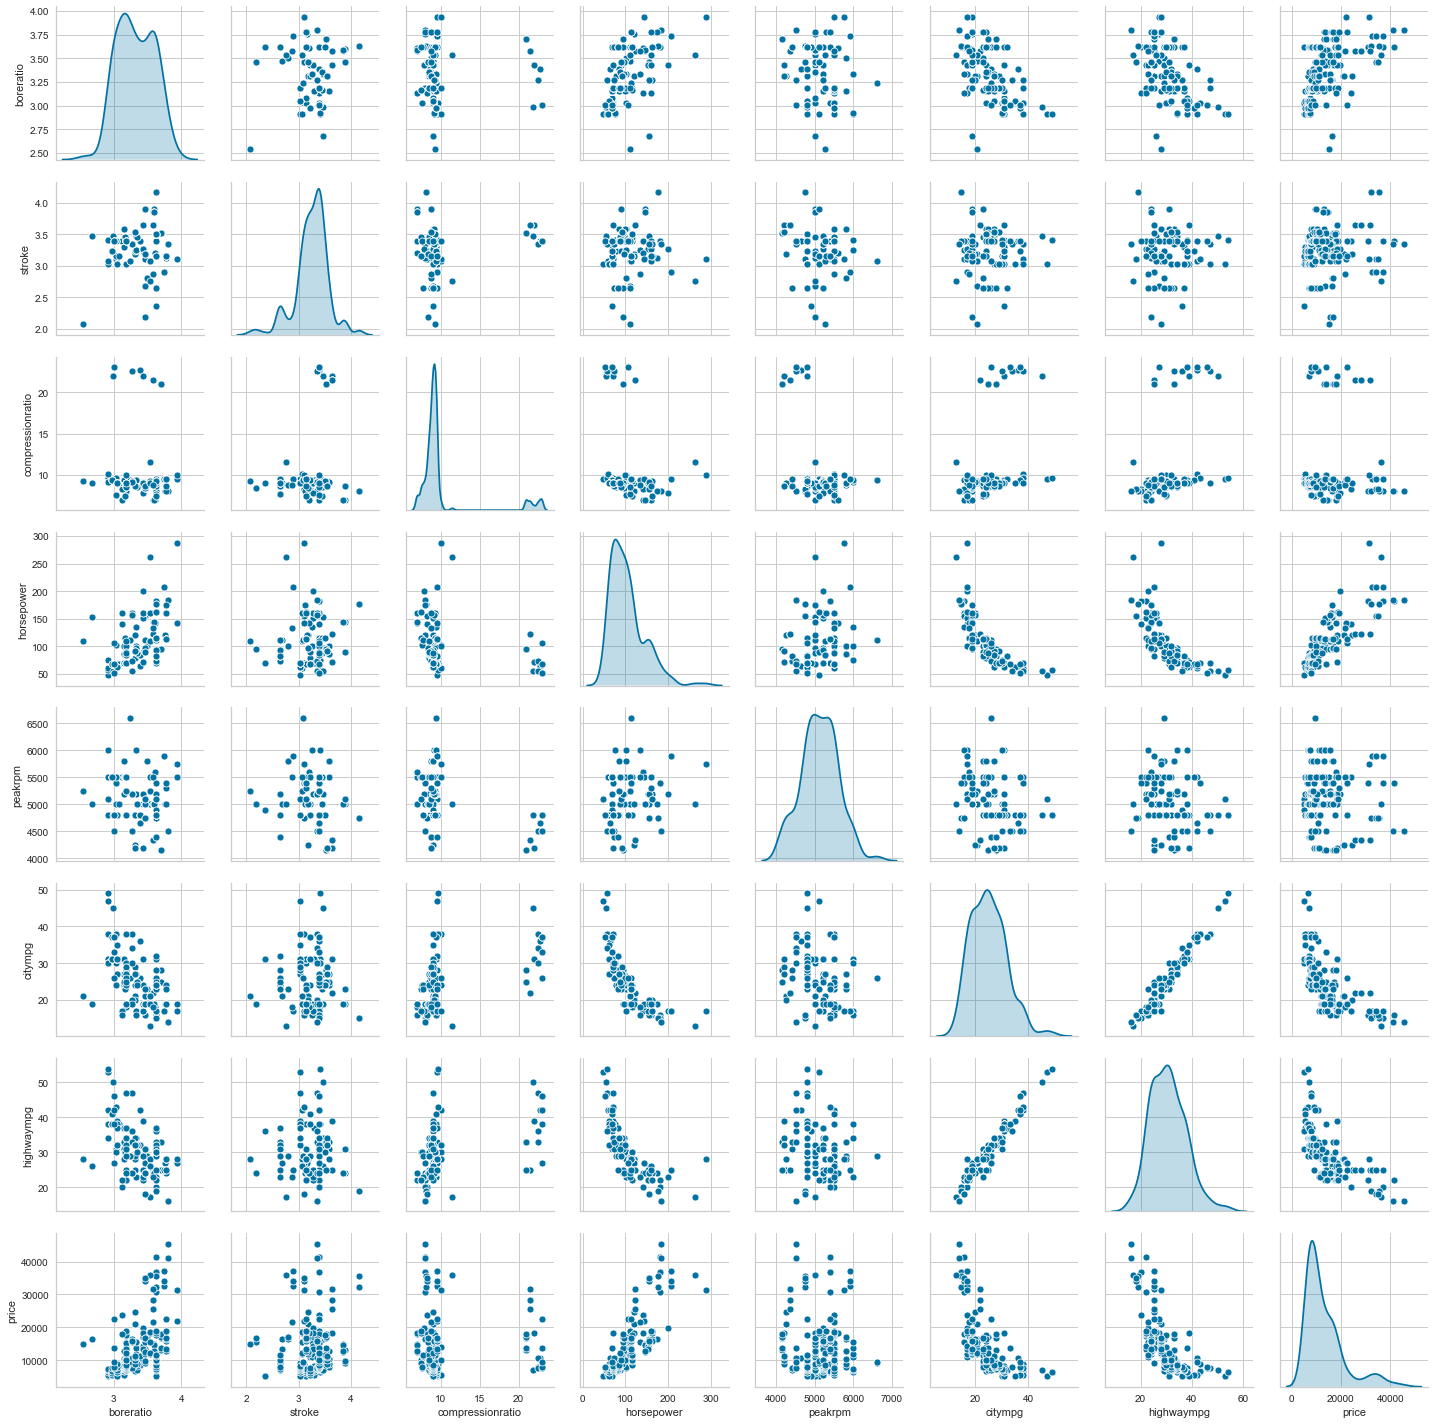

In [1602]:
sns.pairplot(dataset, diag_kind="kde", vars=['boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price'])
plt.show()

Stroke, Compressionratio, Peakrpm doesn't affect price. There is not a linear relationship. I will drop these variables as well.

Firstly, I will analyze the relationship between categorical variables and the price.

In [1603]:
categorical_columns = ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem']
categorical_data = dataset[categorical_columns]

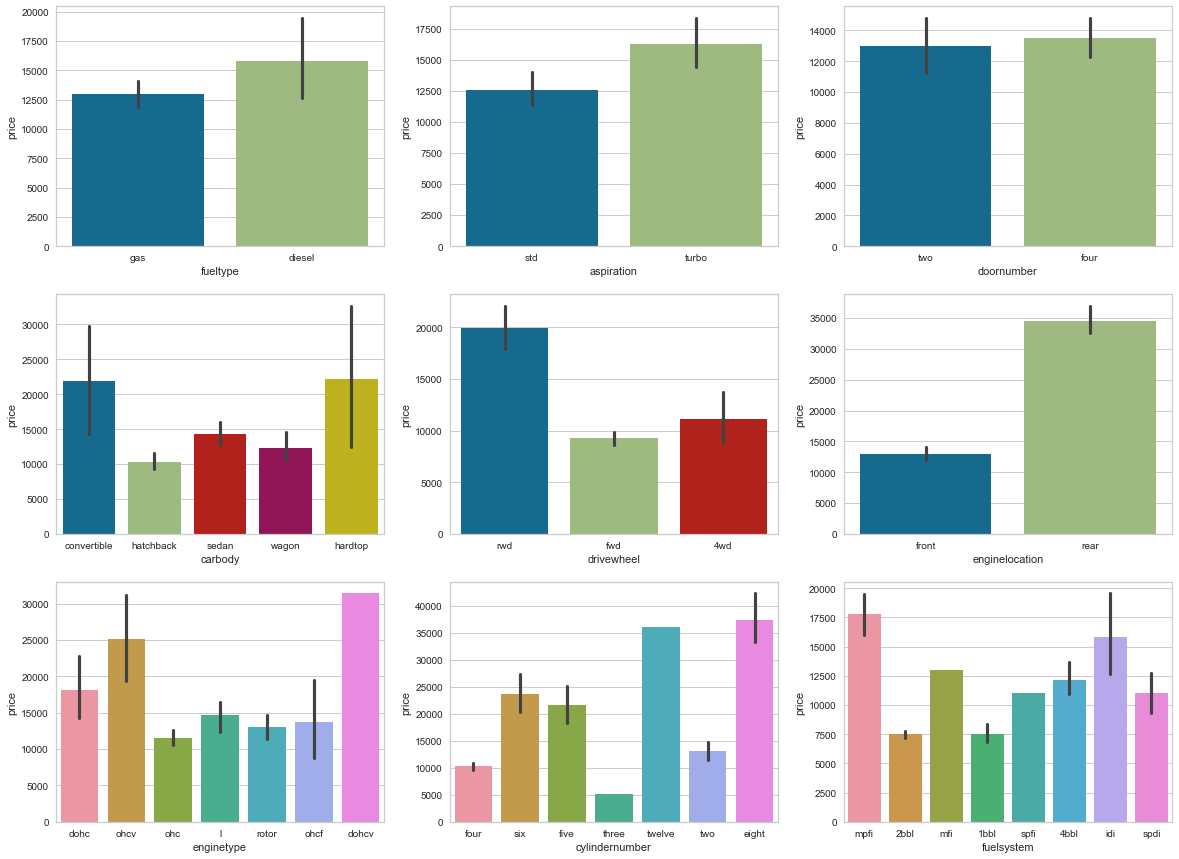

In [1604]:
plt.figure(figsize=(20,15))
for index, item in enumerate(categorical_columns, 1):
    plt.subplot(3,3,index)
    sns.barplot(x = item, y = 'price', data = dataset)
plt.show()  

* diesel-powered cars more expensive than the gas-powered cars. 
* convertible and hardop is more expensive than sedan, hatchback, and wagon.
* rwd drivewheel is more expensive than fwd and 4wd.
* rear engine location is more expensive.
* If the cylinder number is high, price is high.
* mpfi and idi fuel systems is relatively expensive than other types.

# 4. Data Preparation

I will check Pearson Correlation to investigate the linear relationship between two continuous variables. If the features have a weak relationship with the price, I will drop from the dataset.

I will also check P-value to analyze the correlation is statistically significant or not. It is generally accepted that if the value is above 0.05, the correlation is not significant. If it is below 0.05, the correlation is significant.

In [1605]:
from scipy import stats
numerical_columns = dataset.select_dtypes(exclude='object').columns
for i in (list(numerical_columns)):
    pearson_coef, p_value = stats.pearsonr(dataset[i], dataset['price'])
    print(i.capitalize(), "Pearson Correlation:", pearson_coef, "P-value:", p_value)
    print("The correlation is not significant:", p_value>0.05)
    print()

Symboling Pearson Correlation: -0.07997822464270347 P-value: 0.25431175848636967
The correlation is not significant: True

Wheelbase Pearson Correlation: 0.57781559829215 P-value: 1.1828204863378005e-19
The correlation is not significant: False

Carlength Pearson Correlation: 0.6829200156779622 P-value: 1.6787066240746602e-29
The correlation is not significant: False

Carwidth Pearson Correlation: 0.7593252997415114 P-value: 9.627437876120389e-40
The correlation is not significant: False

Carheight Pearson Correlation: 0.11933622657049443 P-value: 0.08832832352275669
The correlation is not significant: True

Curbweight Pearson Correlation: 0.8353048793372966 P-value: 1.2144448264032206e-54
The correlation is not significant: False

Enginesize Pearson Correlation: 0.8741448025245117 P-value: 1.3547637598648421e-65
The correlation is not significant: False

Boreratio Pearson Correlation: 0.5531732367984437 P-value: 7.907922278249421e-18
The correlation is not significant: False

Stroke P

Symboling, Carheight, Stroke, Compressionratio, Peakrpm has a weak relationship with Price. The correlation between these variables and the price is not statistically significant. I will drop them from the dataset.

Wheelbase, Boreratio has a moderate relationship with Price. The correlation is statistically significant.

Carlength, Carwidth, Curbweight, Enginesize, Horsepower has a strong positive relationship with Price. The correlation is statistically significant.

Citympg, Highwaympg has a strong negative relationship with Price. The correlation is statistically significant.

On the other hand, door number has no relationship with the price at all. It is clear visually.

In [1606]:
dataset.drop(['symboling', 'carheight', 'stroke', 'compressionratio', 'peakrpm', 'doornumber'], axis=1, inplace=True)

In [1607]:
print(dataset.shape)

(205, 19)


In [1608]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 1 to 205
Data columns (total 19 columns):
CarName           205 non-null object
fueltype          205 non-null object
aspiration        205 non-null object
carbody           205 non-null object
drivewheel        205 non-null object
enginelocation    205 non-null object
wheelbase         205 non-null float64
carlength         205 non-null float64
carwidth          205 non-null float64
curbweight        205 non-null int64
enginetype        205 non-null object
cylindernumber    205 non-null object
enginesize        205 non-null int64
fuelsystem        205 non-null object
boreratio         205 non-null float64
horsepower        205 non-null int64
citympg           205 non-null int64
highwaympg        205 non-null int64
price             205 non-null float64
dtypes: float64(5), int64(5), object(9)
memory usage: 42.0+ KB
None


### Converting to numerical values

I will add "cars category" column to the dataset according to car prices. I will group cars as budget friendly, medium range, expensive cars. I will drop "cars name" column as I will add "cars category" column.

In [1609]:
data_new = dataset.copy()
t_price = data_new.groupby(['CarName'])['price'].mean()
data_new = data_new.merge(t_price.reset_index(), how='left', on='CarName')
bins = [0,10000,20000,40000]
label =['Budget_Friendly','Medium_Range','Expensive_Cars']
dataset['Cars_Category'] = pd.cut(data_new['price_y'], bins, right=False, labels=label)
dataset.drop("CarName", axis=1, inplace=True)
dataset.head()

,fueltype,aspiration,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg,price,Cars_Category
car_ID,,,,,,,,,,,,,,,,,,,
1,gas,std,convertible,rwd,front,88.6,168.8,64.1,2548,dohc,four,130,mpfi,3.47,111,21,27,13495.0,Medium_Range
2,gas,std,convertible,rwd,front,88.6,168.8,64.1,2548,dohc,four,130,mpfi,3.47,111,21,27,16500.0,Medium_Range
3,gas,std,hatchback,rwd,front,94.5,171.2,65.5,2823,ohcv,six,152,mpfi,2.68,154,19,26,16500.0,Medium_Range
4,gas,std,sedan,fwd,front,99.8,176.6,66.2,2337,ohc,four,109,mpfi,3.19,102,24,30,13950.0,Medium_Range
5,gas,std,sedan,4wd,front,99.4,176.6,66.4,2824,ohc,five,136,mpfi,3.19,115,18,22,17450.0,Medium_Range


I will convert categorical variables to numerical variables. Categorical variables in the dataset are nominal. I can apply OneHotEncoder. 

In [1610]:
column = ['fueltype','aspiration','carbody', 'drivewheel', 'enginelocation', 'enginetype','cylindernumber', 'fuelsystem', 'Cars_Category']
dummies = pd.get_dummies(dataset[column], drop_first = True)
dataset = pd.concat([dataset, dummies], axis = 1)
dataset.drop(column, axis = 1, inplace = True)

In [1611]:
print(dataset.shape)

(205, 40)


### Rescaling

Ordinary Least Squares method does not make normality assumptions about the data. It makes normality assumptions about the residuals. I will not transform the data to ensure Gaussian distribution. 

On the other hand, linear regression is sensitive to outliers. Quantile Transformer is robust to outliers. It will transform the variables and handle the outliers in the dataset.

In [1612]:
from sklearn.preprocessing import QuantileTransformer
transform =  QuantileTransformer(n_quantiles=205)
columns = ['wheelbase', 'carlength', 'carwidth', 'curbweight','enginesize','boreratio','horsepower','citympg','highwaympg','price']
dataset[columns] = transform.fit_transform(dataset[columns]) 

In [1613]:
print(dataset.columns.values)

['wheelbase' 'carlength' 'carwidth' 'curbweight' 'enginesize' 'boreratio'
 'horsepower' 'citympg' 'highwaympg' 'price' 'fueltype_gas'
 'aspiration_turbo' 'carbody_hardtop' 'carbody_hatchback' 'carbody_sedan'
 'carbody_wagon' 'drivewheel_fwd' 'drivewheel_rwd' 'enginelocation_rear'
 'enginetype_dohcv' 'enginetype_l' 'enginetype_ohc' 'enginetype_ohcf'
 'enginetype_ohcv' 'enginetype_rotor' 'cylindernumber_five'
 'cylindernumber_four' 'cylindernumber_six' 'cylindernumber_three'
 'cylindernumber_twelve' 'cylindernumber_two' 'fuelsystem_2bbl'
 'fuelsystem_4bbl' 'fuelsystem_idi' 'fuelsystem_mfi' 'fuelsystem_mpfi'
 'fuelsystem_spdi' 'fuelsystem_spfi' 'Cars_Category_Medium_Range'
 'Cars_Category_Expensive_Cars']


These are all the columns in the dataset now.

### Correlation Between Variables

Linear regression assumes the independent variables are not related with each other. If the correlation degree is high, it will cause problems when we fit the model.

To check multicollinearity, I will use heatmap and VIF.

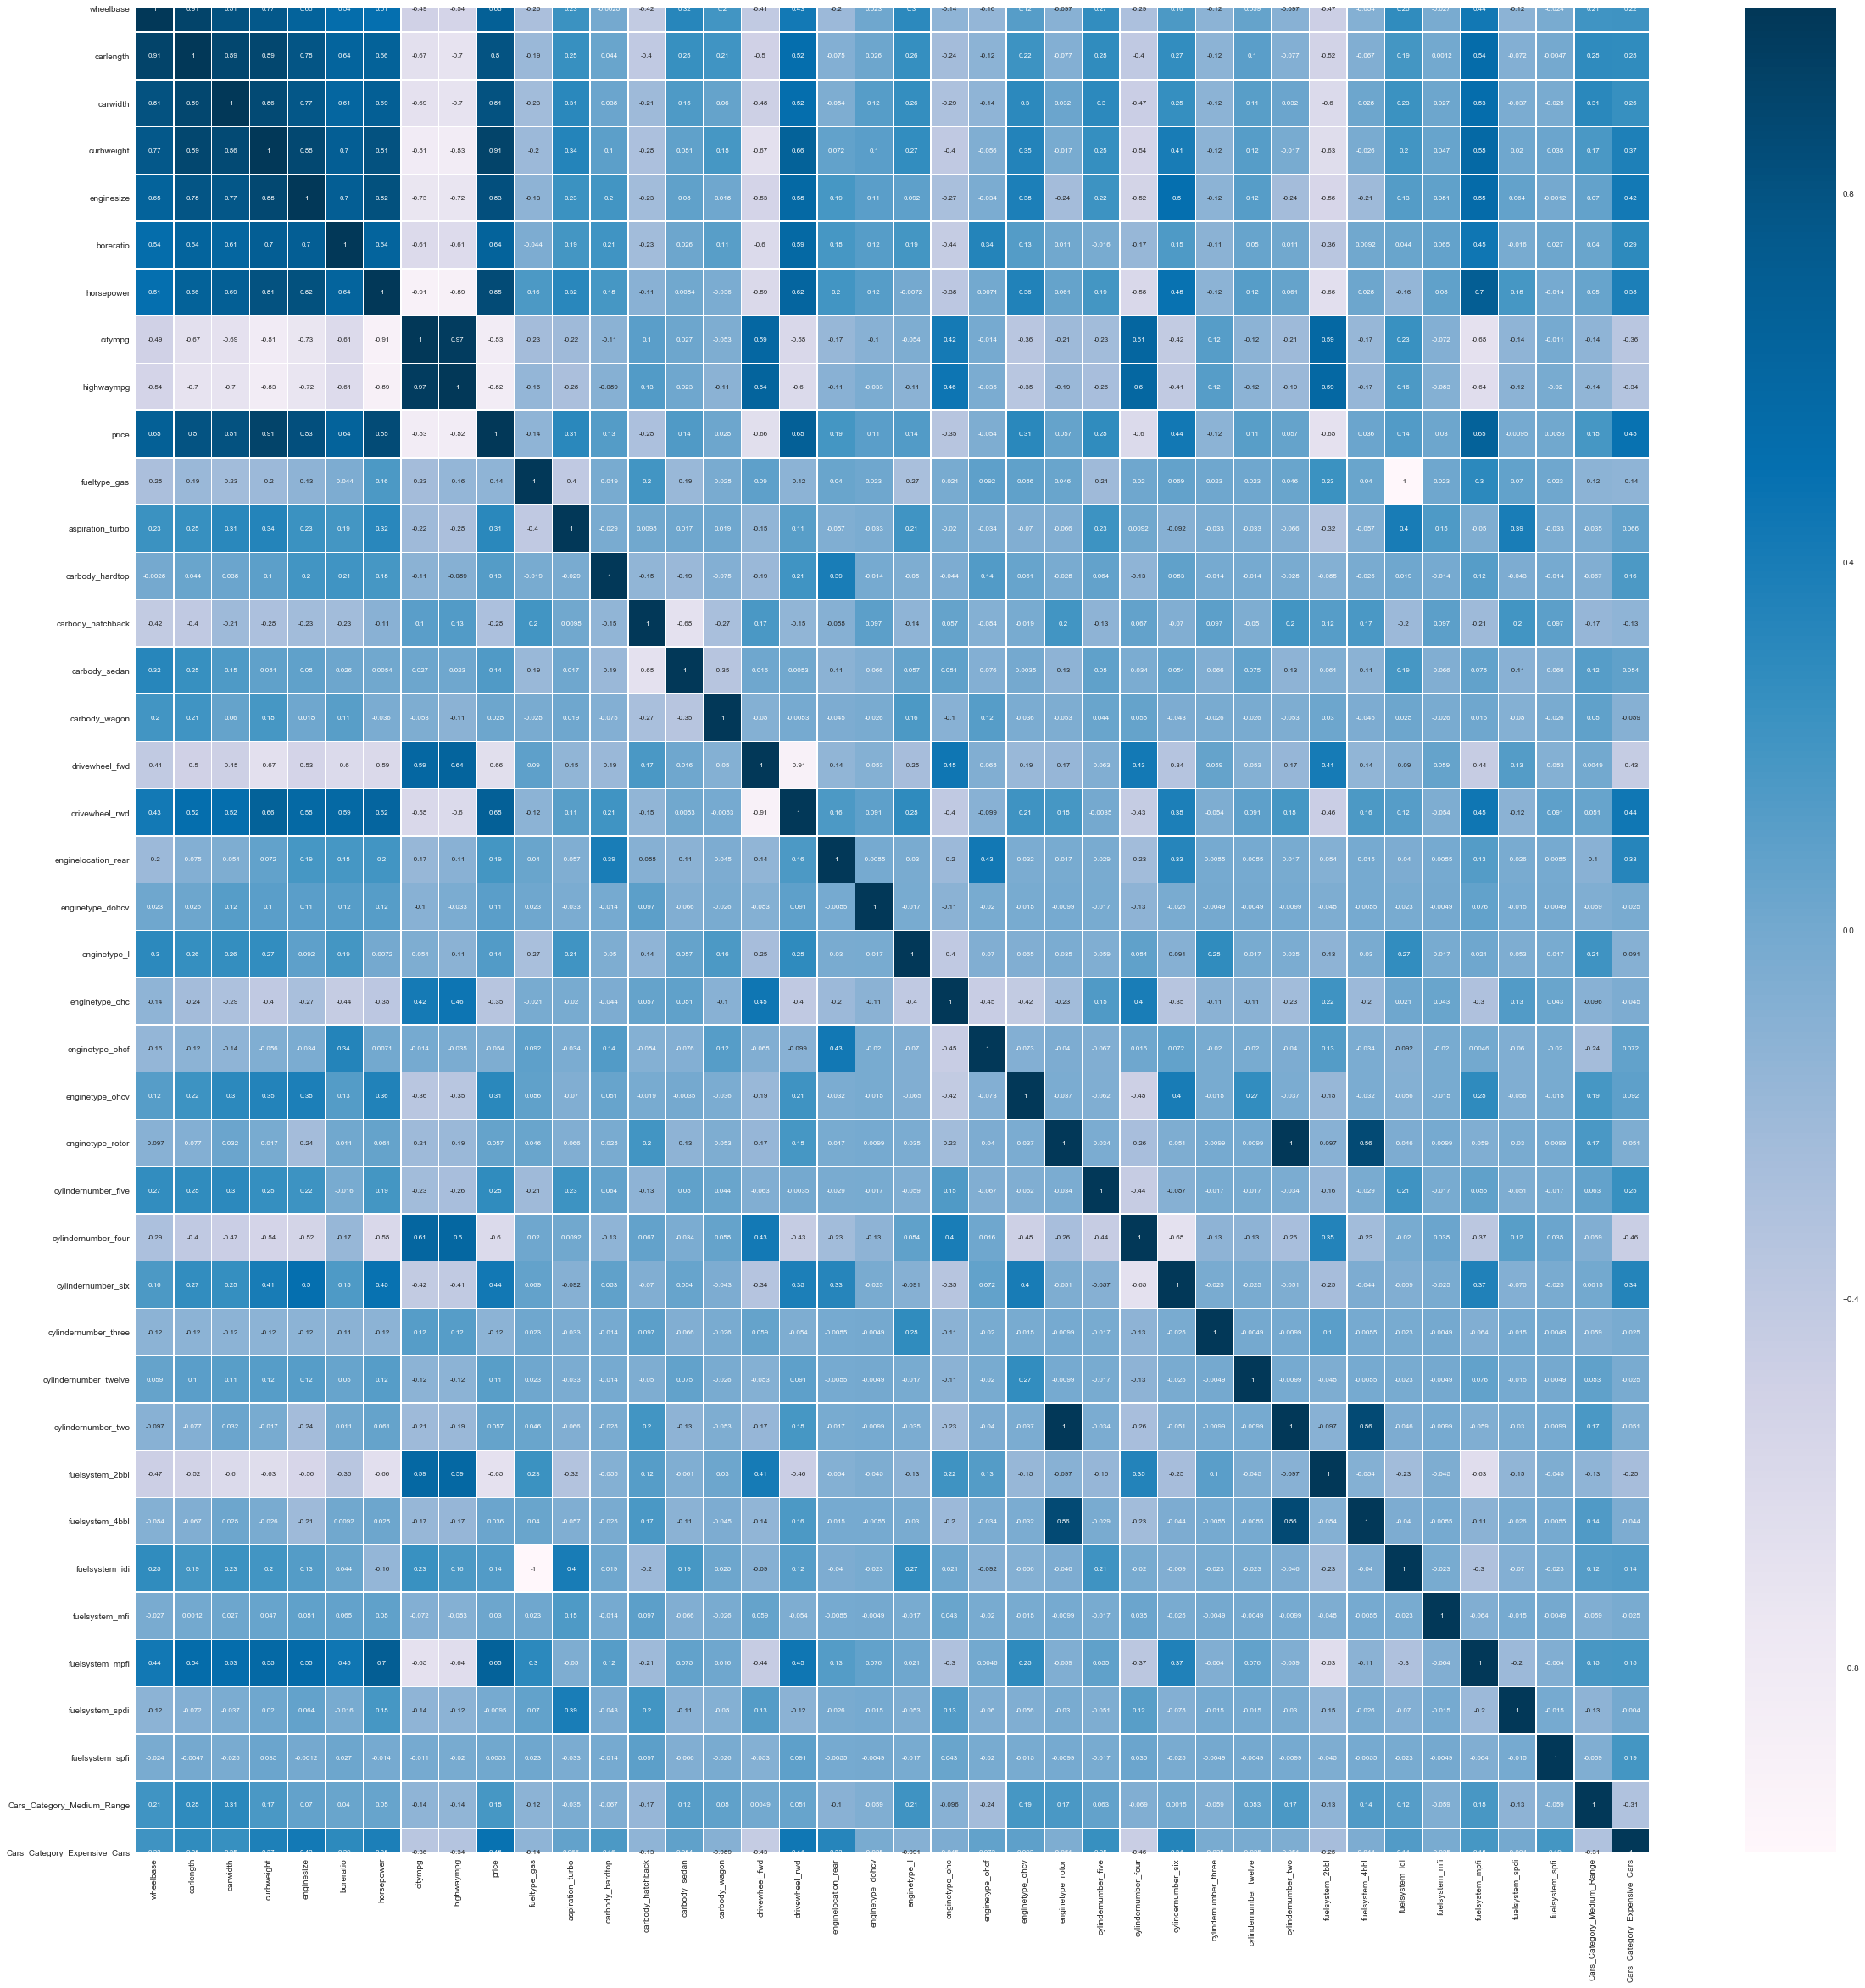

In [1614]:
plt.figure(figsize = (40, 40))
sns.heatmap(dataset.corr(method ='pearson'), cmap='PuBu', annot=True, linewidths=.5, annot_kws={'size':8})
plt.show()

In [1615]:
print(dataset.corr(method ='pearson').unstack().sort_values().drop_duplicates())

fuelsystem_idi  fueltype_gas     -1.000000
drivewheel_rwd  drivewheel_fwd   -0.911996
horsepower      citympg          -0.910186
highwaympg      horsepower       -0.886050
                curbweight       -0.834628
                                    ...   
carlength       curbweight        0.890270
curbweight      price             0.909073
wheelbase       carlength         0.912553
highwaympg      citympg           0.967852
wheelbase       wheelbase         1.000000
Length: 726, dtype: float64


Multicollinearity exists among predictors. After even transforming the variables, there is a strong relationships between independent variables. For this reason, I will use Variation Inflation Factor (VIF) to detect multicollinearity and to eliminate these variables from the dataset.

### Checking Pearson Correlation

Before eliminating correlated variables, I will check Pearson Correlation and p values. I will eliminate the features based on the accordingly.

In [1616]:
data = list(dataset.columns)
for i in data:
    pearson_coef, p_value = stats.pearsonr(dataset[i], dataset['price'])
    print(i.capitalize(), "Pearson Correlation:", pearson_coef, "P-value:", p_value)
    print("The correlation is not significant:", p_value>0.05)
    if p_value>0.05:
        dataset.drop(i, axis=1, inplace=True)
    print()

Wheelbase Pearson Correlation: 0.6817107656710274 P-value: 2.3005688205774345e-29
The correlation is not significant: False

Carlength Pearson Correlation: 0.8042596260051321 P-value: 9.141667102792944e-48
The correlation is not significant: False

Carwidth Pearson Correlation: 0.811360742235464 P-value: 3.1732839420934035e-49
The correlation is not significant: False

Curbweight Pearson Correlation: 0.9090733091614547 P-value: 3.974518946786223e-79
The correlation is not significant: False

Enginesize Pearson Correlation: 0.8259350805326382 P-value: 2.0076278459247288e-52
The correlation is not significant: False

Boreratio Pearson Correlation: 0.6438697199951691 P-value: 2.161528670735205e-25
The correlation is not significant: False

Horsepower Pearson Correlation: 0.8542299637663318 P-value: 1.400343562786586e-59
The correlation is not significant: False

Citympg Pearson Correlation: -0.8292981222348645 P-value: 3.3269993007553006e-53
The correlation is not significant: False

High

In [1617]:
print(dataset.shape)

(205, 28)


### Variation Inflation Factor (VIF)

A variance inflation factor(VIF) detects multicollinearity in regression analysis. I will select the features with VIF that is below 10.

In [1618]:
X = dataset.drop('price', axis=1)
y = dataset['price']

In [1619]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["variables"] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for index,column in enumerate(X.columns):
    print(index, column, vif['vif'][index])
    if vif['vif'][index]>10:
        vif = vif.drop([index], axis=0)

0 wheelbase 9.610305075087423
1 carlength 20.15831144262411
2 carwidth 8.508959620962676
3 curbweight 26.2685755167176
4 enginesize 13.504545076432313
5 boreratio 5.609580917082398
6 horsepower 20.070914918302197
7 citympg 34.03505241361841
8 highwaympg 25.272106127504287
9 fueltype_gas 193.29413714664406
10 aspiration_turbo 3.3586391827186795
11 carbody_hatchback 3.110129500620849
12 carbody_sedan 2.5441540917507317
13 drivewheel_fwd 9.706620640438864
14 drivewheel_rwd 10.052422775584429
15 enginelocation_rear 1.998191219014369
16 enginetype_l 2.7375253820197334
17 enginetype_ohc 4.201562475492343
18 enginetype_ohcv 2.5132368287659275
19 cylindernumber_five 3.654529948647788
20 cylindernumber_four 8.632209994300728
21 cylindernumber_six 4.749663800400231
22 fuelsystem_2bbl 4.280867919173998
23 fuelsystem_idi 29.51888958622272
24 fuelsystem_mpfi 4.327698312459471
25 Cars_Category_Medium_Range 2.0311880939867493
26 Cars_Category_Expensive_Cars 2.2597686646237647


In [1620]:
print(vif)

                       variables       vif
0                      wheelbase  9.610305
2                       carwidth  8.508960
5                      boreratio  5.609581
10              aspiration_turbo  3.358639
11             carbody_hatchback  3.110130
12                 carbody_sedan  2.544154
13                drivewheel_fwd  9.706621
15           enginelocation_rear  1.998191
16                  enginetype_l  2.737525
17                enginetype_ohc  4.201562
18               enginetype_ohcv  2.513237
19           cylindernumber_five  3.654530
20           cylindernumber_four  8.632210
21            cylindernumber_six  4.749664
22               fuelsystem_2bbl  4.280868
24               fuelsystem_mpfi  4.327698
25    Cars_Category_Medium_Range  2.031188
26  Cars_Category_Expensive_Cars  2.259769


In [1621]:
print(list(vif['variables']))

['wheelbase', 'carwidth', 'boreratio', 'aspiration_turbo', 'carbody_hatchback', 'carbody_sedan', 'drivewheel_fwd', 'enginelocation_rear', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcv', 'cylindernumber_five', 'cylindernumber_four', 'cylindernumber_six', 'fuelsystem_2bbl', 'fuelsystem_mpfi', 'Cars_Category_Medium_Range', 'Cars_Category_Expensive_Cars']


# 5. Building the Model

In [1622]:
columns = list(vif['variables'])
data = dataset [columns]
data = pd.concat([data, dataset['price']], axis=1)

In [1623]:
from sklearn.model_selection import train_test_split
X = data.drop('price', axis=1)
y = data ['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state=42)

In [1624]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
lr = LinearRegression()
lr.fit(X_train,y_train)
pred_test = lr.predict(X_test)
pred_train = lr.predict(X_train)
print("R Squared Value of Train Data: {}".format(r2_score(y_train, pred_train)))
print("R Squared Value of Test Data: {}".format(r2_score(y_test, pred_test)))

R Squared Value of Train Data: 0.8873698974233928
R Squared Value of Test Data: 0.8718228807686723


# 6. Evaluating The Model

I will check the residual normality assumption visually. Errors should be normally distributed.

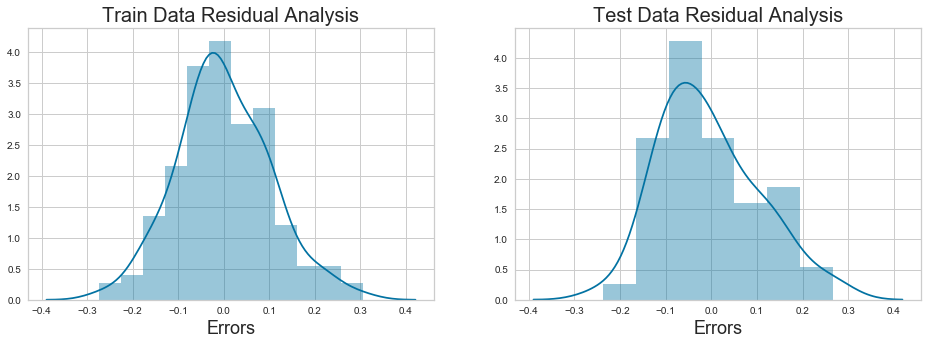

In [1625]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
sns.distplot((y_train - pred2))
plt.title('Train Data Residual Analysis', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 18)

plt.subplot(1,2,2)
sns.distplot((y_test - pred))
plt.title('Test Data Residual Analysis', fontsize = 20)              
plt.xlabel('Errors', fontsize = 18)

plt.show()

I will check Homoscedasticity. There should not be specific pattern in the distribution of residuals.

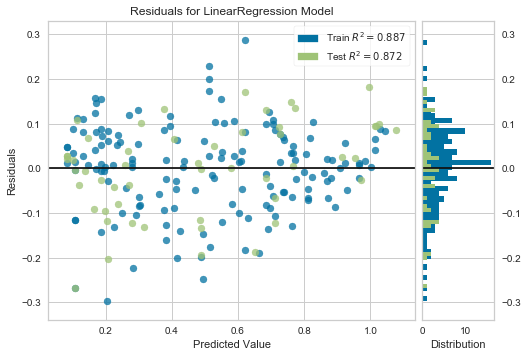

In [1626]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()
plt.show()